# A Cloud Price Comparison
How do cloud providers stack up?
 
Making apples to apples comparisons between different cloud providers is very difficult, because each one offers instances with varying vCPUs, RAM, SSD space and HDD space. To further obfuscate matters, slightly different billing systems, promises of arcane discounting, only providing pricing in USD, and inconsistent naming conventions are sprinkled throughout.

As an attempt to provide a clearer price comparison, I'll be using [multiple linear regression](https://en.wikipedia.org/wiki/Linear_regression) to "[normalise](http://bit.ly/2xIUM5C)" the pricing of compute instances across different cloud providers.

In essence, **If every cloud provider offered the same size compute instances, how expensive would they be?**

## Todo

* Account for GST

 ## Importing libraries

In [80]:
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import requests
import json
from bs4 import BeautifulSoup
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## The dataset

I'll be taking the price tables of:
* Google Cloud - [Predefined machine types](https://cloud.google.com/compute/pricing#predefined_machine_types)
* AWS - [On demand instances](https://aws.amazon.com/ec2/pricing/on-demand/)
* Azure - [Linux virtual machines](https://azure.microsoft.com/en-us/pricing/details/virtual-machines/linux/)

and converting them into the instance sizes offered by [Catalyst Cloud](https://www.catalyst.net.nz/catalyst-cloud/prices). You can find the datasets and their sources [here](https://github.com/catalyst-cloud/catalystcloud-price-comparison/raw/master/dataset/Cloud%20price%20comparison.ods).

In [81]:
# The list of URLS

# Catalyst Cloud's price list
catalyst_url = 'https://catalystcloud.nz/services/iaas/compute'

# AWS's bulk price list JSON, for the Sydney region (ap-southeast-2)
aws_url = 'https://pricing.us-east-1.amazonaws.com/offers/v1.0/aws/AmazonEC2/current/ap-southeast-2/index.json'
aws_raw_location = 'dataset/raw_aws_bulk.json'
acceptable_instance_families = [
    'General purpose',
    'Memory optimized',
    'Micro instances',
    'Storage optimized'
]
unacceptable_instance_families = [
    'Compute optimized',
    'GPU instance'
]

# Google Cloud's prices
google_url = 'https://cloud.google.com/compute/pricing'
google_price_type = 'syd-hourly'


# List of existing dataset files
datasets = os.listdir('dataset')

fresh = False

### Catalyst Cloud prices
Scraping the Catalyst Cloud compute page for prices

In [86]:
catalyst_price_page_html = requests.get(catalyst_url).text 
catalyst_price_page = BeautifulSoup(catalyst_price_page_html, 'html.parser')

catalyst_price_table = catalyst_price_page.find(attrs={'class': 'service-price-table'}).tbody
catalyst_price_rows = catalyst_price_table.find_all('tr')

catalyst_prices = []

for row in catalyst_price_rows:
    catalyst_price_cells = list(row.stripped_strings)
    catalyst_prices.append({
        'Name': catalyst_price_cells[0],
        'vCPU': float(catalyst_price_cells[1]),
        'RAM, GB': float(catalyst_price_cells[2]),
        'Price per hour, NZD (ex GST)': float(catalyst_price_cells[3].strip('$')),
        'SSD storage, GB': .0,
        'HDD storage, GB': .0
    })

In [87]:
catalyst_prices

[{'HDD storage, GB': 0.0,
  'Name': 'c1.c1.r05',
  'Price per hour, NZD (ex GST)': 0.03,
  'RAM, GB': 0.5,
  'SSD storage, GB': 0.0,
  'vCPU': 1.0},
 {'HDD storage, GB': 0.0,
  'Name': 'c1.c1r1',
  'Price per hour, NZD (ex GST)': 0.044,
  'RAM, GB': 1.0,
  'SSD storage, GB': 0.0,
  'vCPU': 1.0},
 {'HDD storage, GB': 0.0,
  'Name': 'c1.c1r2',
  'Price per hour, NZD (ex GST)': 0.062,
  'RAM, GB': 2.0,
  'SSD storage, GB': 0.0,
  'vCPU': 1.0},
 {'HDD storage, GB': 0.0,
  'Name': 'c1.c1r4',
  'Price per hour, NZD (ex GST)': 0.098,
  'RAM, GB': 4.0,
  'SSD storage, GB': 0.0,
  'vCPU': 1.0},
 {'HDD storage, GB': 0.0,
  'Name': 'c1.c2r1',
  'Price per hour, NZD (ex GST)': 0.07,
  'RAM, GB': 1.0,
  'SSD storage, GB': 0.0,
  'vCPU': 2.0},
 {'HDD storage, GB': 0.0,
  'Name': 'c1.c2r2',
  'Price per hour, NZD (ex GST)': 0.088,
  'RAM, GB': 2.0,
  'SSD storage, GB': 0.0,
  'vCPU': 2.0},
 {'HDD storage, GB': 0.0,
  'Name': 'c1.c2r4',
  'Price per hour, NZD (ex GST)': 0.124,
  'RAM, GB': 4.0,
  'SSD

### AWS prices

Downloading AWS's JSON price list, if you haven't already downloaded it.

In [30]:
if aws_raw_location.split('/')[1] not in datasets or fresh:
    aws_bulk_json_requeset = requests.get(aws_url)
    aws_bulk_json = aws_bulk_json_requeset.json()
    with open(aws_raw_location, 'w') as aws_raw_file:
        json.dump(aws_bulk_json, aws_raw_file)
    print('Downloaded most recent AWS price list.')
else:
    print('AWS raw dataset already dowloaded.')

AWS raw dataset already dowloaded.


Extracting the specific relevant prices from the raw AWS file, and putting them in a consistant, usable format.

In [38]:
with open(aws_raw_location, 'r') as aws_raw_file:
    aws_raw_json = json.load(aws_raw_file)
    
    stuff = set()
            
    for product in aws_raw_json['products']:
        
        family = aws_raw_json['products'][product]['productFamily']
        
        if family == 'Compute Instance':
            
            stuff.add(aws_raw_json['products'][product]['attributes']['instanceFamily'])

### Google Cloud prices

Scraping Google Cloud's documentation for prices of custom instance sizes.

In [68]:
google_price_page_html = requests.get(google_url).text
google_price_page = BeautifulSoup(google_price_page_html, 'html.parser')

google_custom_compute_price_table = google_price_page.find(id='custommachinetypepricing').find_next('table')

google_rows = google_custom_compute_price_table.find_all('tr')

google_vcpu_text = google_rows[1].find_all('td')[1][google_price_type]
google_mem_text = google_rows[2].find_all('td')[1][google_price_type]



Turn that info into a CSV for storage.

### Azure cloud prices

### Ingesting the datasets
Importing the datasets.

In [25]:
catalyst_dataset = pd.read_csv("dataset/Rigorious Cloud price comparison - Exportable Catalyst prices.csv")
google_dataset = pd.read_csv("dataset/Rigorious Cloud price comparison - Exportable Google prices.csv")
aws_dataset = pd.read_csv("dataset/Rigorious Cloud price comparison - Exportable AWS prices.csv")
azure_dataset = pd.read_csv("dataset/Rigorious Cloud price comparison - Exportable Azure prices.csv")

Previewing the datasets.

In [26]:
catalyst_dataset.head(6)

,Flavour,vCPUs,RAM (GiB),HDD (GB),SSD (GB),Price per hour (NZD)
0,c1.c1r1,1.0,1.0,0.0,0.0,0.044
1,c1.c1r2,1.0,2.0,0.0,0.0,0.062
2,c1.c1r4,1.0,4.0,0.0,0.0,0.098
3,c1.c2r1,2.0,1.0,0.0,0.0,0.070
4,c1.c2r2,2.0,2.0,0.0,0.0,0.088
5,c1.c2r4,2.0,4.0,0.0,0.0,0.124


Now we'll split the data into NumPy arrays of input features (X) and labels (Y).

In [27]:
def split_dataset (dataset):
    x = dataset[["vCPUs", "RAM (GiB)", "HDD (GB)", "SSD (GB)"]].values
    y = dataset["Price per hour (NZD)"].values
    
    return (x, y)

In [28]:
catalyst_x, catalyst_y = split_dataset(catalyst_dataset)
google_x, google_y = split_dataset(google_dataset)
aws_x, aws_y = split_dataset(aws_dataset)
azure_x, azure_y = split_dataset(azure_dataset)

## The math
To analyse this dataset, we'll be using [multiple linear regression](https://en.wikipedia.org/wiki/Linear_regression) to predict the prices of compute instance flavors if they were being offered by cloud providers that do not typically offer that sized flavor.

The multiple linear regression models will draw a hyperplane across our data space (in this case, 5 dimensional space) that comes as close as possible to intersecting every data point in our dataset. You can see an example of this (in 2 dimensional space) by Khan academy below.

In [29]:
from IPython.core.display import display, HTML
display(HTML('<iframe width="840" height="472" src="https://www.youtube-nocookie.com/embed/GAmzwIkGFgE?rel=0" frameborder="0" allowfullscreen></iframe>'))

By then finding a point on the hyperplane that intersects with our vCPUs, RAM, HDD, and SSD axes, we can find the predicted price. This will give us a way to estimate the price of a flavour if it were offered by various cloud providers, even if they do not offer it.

I've used linear regression as the predictive algorithm because I'm assuming that cloud providers scale their pricing in a linear patern. For example, Catalyst Cloud decides the price of their flavors with the equation: 

Price/hour = (RAM gb x 0.18) + (vCPU x 0.026)

First we'll initialise the regression models, and train them on the cloud providers' prices.

In [30]:
# Initialise regressors
catalyst_linear = LinearRegression()
google_linear = LinearRegression()
aws_linear = LinearRegression()
azure_linear = LinearRegression()

# Train regressors
catalyst_linear.fit(catalyst_x, catalyst_y)
google_linear.fit(google_x, google_y)
aws_linear.fit(aws_x, aws_y)
azure_linear.fit(azure_x, azure_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now we have the models predict the other providers' instance prices. By having all providers predict the prices of all other providers, we can see if the pattern is maintained across different models.

In [31]:
# Predict Catalyst X
google_cata_price = google_linear.predict(catalyst_x)
aws_cata_price = aws_linear.predict(catalyst_x)
azure_cata_price = azure_linear.predict(catalyst_x)

# Predict Google X
aws_goog_price = aws_linear.predict(google_x)
azure_goog_price = azure_linear.predict(google_x)
catalyst_goog_price = catalyst_linear.predict(google_x)

# Predict AWS X
google_aws_price = google_linear.predict(aws_x)
azure_aws_price = azure_linear.predict(aws_x)
catalyst_aws_price = catalyst_linear.predict(aws_x)

# Predict Azure X
google_azure_price = google_linear.predict(azure_x)
aws_azure_price = aws_linear.predict(azure_x)
catalyst_azure_price = catalyst_linear.predict(azure_x)

## The results

Now we have the results together, where we can compare the prices against each other on an even scale.

A good scientist would, at this point, verify their results by comparing an intersection between the predicted output and the actual output. I would love to do this. However I could find no such intersection.

You can find the datasets this analysis is based on [here](https://github.com/catalyst-cloud/catalystcloud-price-comparison/raw/master/dataset/Cloud%20price%20comparison.ods), and a chart plotting this data, [here](https://object-storage.nz-por-1.catalystcloud.io/v1/AUTH_8ccc3286887e49cb9a40f023eba693b4/catalyst-cloud-price-comp/).

Please note that the X axis is a range from zero to the number of flavors offered by each provider. Each number on the X axis represents a single flavor by the provider we are predicting. I've done it this way because the plotting method does not support non-numerical axis ticks.

In [32]:
def graph_pred (names, predictions):
    flavors_num = predictions[0].shape[0]
    for index, name in enumerate(names):
        plt.plot(range(flavors_num), predictions[index], label=names[index])
    plt.legend(loc=2)

### Predicting Catalyst Cloud

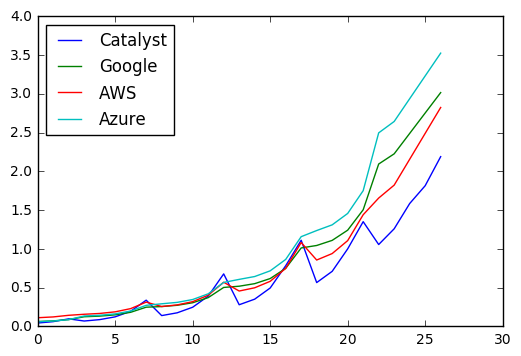

In [33]:
graph_pred([
        "Catalyst", "Google", "AWS", "Azure"
    ], [
        catalyst_y, google_cata_price, aws_cata_price, azure_cata_price
    ])

### Predicting Google Cloud

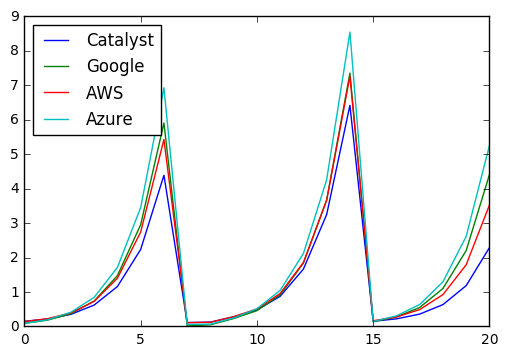

In [34]:
graph_pred([
        "Catalyst", "Google", "AWS", "Azure"
    ], [
        catalyst_goog_price,
        google_y,
        aws_goog_price,
        azure_goog_price,
        
    ])

### Predicting AWS

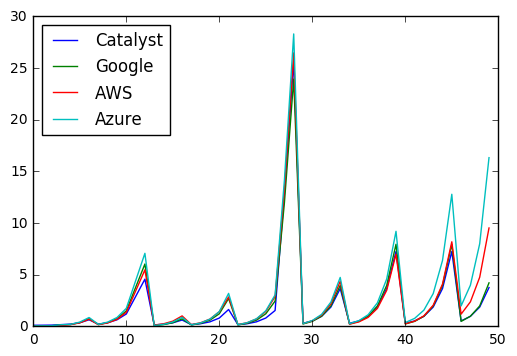

In [35]:
graph_pred([
        "Catalyst", "Google", "AWS", "Azure"
    ], [
        catalyst_aws_price,
        google_aws_price,
        aws_y,
        azure_aws_price,
    ])

### Predicting Azure

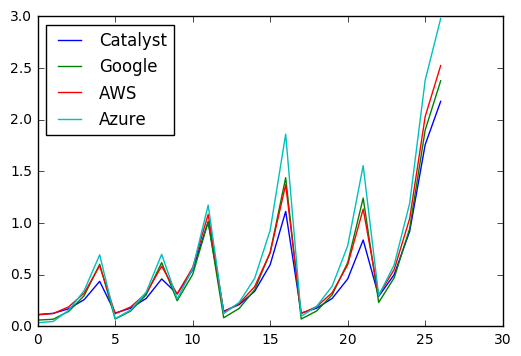

In [36]:
graph_pred([
        "Catalyst", "Google", "AWS", "Azure"
    ], [
        catalyst_azure_price,
        google_azure_price,
        aws_azure_price,
        azure_y
    ])

### Interpreting the results

As you can see, the multiple linear regression model consistently predicts that Catalyst Cloud would offer either the cheapest, or competitively priced compute instances.

While this is by no means a perfect indicator of who is the cheapest and should not be taken as such, it does serve to dispel the idea that Catalyst Cloud is overpriced, or cannot compete with international companies on price.